# 模型选择、欠拟合和过拟合

通过多项式拟合来探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

查看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.0058],
         [-0.4984]]),
 tensor([[ 1.0000e+00, -1.0058e+00,  5.0582e-01, -1.6959e-01,  4.2642e-02,
          -8.5780e-03,  1.4380e-03, -2.0661e-04,  2.5977e-05, -2.9031e-06,
           2.9199e-07, -2.6699e-08,  2.2378e-09, -1.7314e-10,  1.2439e-11,
          -8.3406e-13,  5.2431e-14, -3.1021e-15,  1.7334e-16, -9.1760e-18],
         [ 1.0000e+00, -4.9844e-01,  1.2422e-01, -2.0639e-02,  2.5719e-03,
          -2.5639e-04,  2.1299e-05, -1.5166e-06,  9.4493e-08, -5.2333e-09,
           2.6085e-10, -1.1820e-11,  4.9096e-13, -1.8824e-14,  6.7020e-16,
          -2.2270e-17,  6.9379e-19, -2.0342e-20,  5.6329e-22, -1.4777e-23]]),
 tensor([1.2323, 4.0181]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正常)

weight: [[ 4.9960175  1.1997806 -3.399468   5.6006184]]


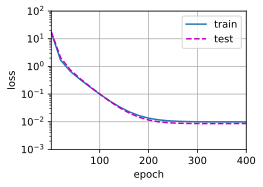

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.5406792 3.2406826]]


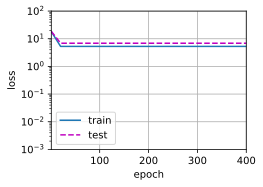

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.9892282   1.2777817  -3.3161616   5.157675   -0.29190347  1.4755238
  -0.20011061  0.04500701  0.21186602 -0.00543663  0.20455757 -0.07053914
   0.10189647 -0.14872248  0.1770936   0.03321001 -0.10538805 -0.11985834
  -0.04925881 -0.0201955 ]]


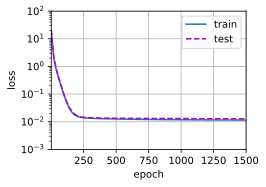

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)